In [96]:
%load_ext watermark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [2]:
%watermark -p pandas,numpy,scipy,sklearn

pandas 0.22.0
numpy 1.12.1
scipy 1.0.0
sklearn 0.19.1


## 1.	(20 points) Implement the Expectation Maximization (EM) algorithm for the  Gaussian Mixture Model in python  

In [ ]:
def em_gmm(xs, pis, mus, sigmas, tol=0.01, max_iter=100):
    
#     def initialize():
#         n, p = xs.shape
#         k = len(pis)
#         return n,p,k
    
    def estep(mus,sigmas,xs,pis):
        n, p = xs.shape
        k = len(pis)
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)
        return ws
    
    def mstep(mus,sigmas,xs,pis,ws):
        k = len(pis)
        n, p = xs.shape
        # recalc  mixing coefficients
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        # recalc mean
        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()
            
        # recalc sigma
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()
              
        return mus,sigmas,xs,pis,ws
      
    def update_ll(mus,sigmas,xs,pis):
        ll_new = 0.0
        n, p = xs.shape
        k = len(pis)
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)
        return ll_new
              
              

    ll_old = 0
    for i in range(max_iter):
        
        ll_new = 0

        # E-step
        ws = estep(mus,sigmas,xs,pis)
        # M-step
        mus,sigmas,xs,pis,ws = mstep(mus,sigmas,xs,pis,ws)

        # update complete log likelihoood
        ll_new = update_ll(mus,sigmas,xs,pis)

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

In [ ]:
np.random.seed(123)

# create data set
n = 1000
mus = np.array([[0,4], [-2,0]])  # Mean -2 numbers for two diemnsional data
sigmas = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]]) # SD
pis = np.array([0.6, 0.4]) # Mixing Coeffiecients
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(pis, mus, sigmas)])

# initial guesses for parameters
pis_seed = np.random.random(2)
pis_seed /= pis_seed.sum()  # Scaling guesses to equal to a sum of 1
mus_seed = np.random.random((2,2))
sigmas_seed = np.array([np.eye(2)] * 2) # generate 2 Identity matrix


In [ ]:
ll1, pis1, mus1, sigmas1 = em_gmm(xs, pis, mus, sigmas)
print("Starting Parameter Values")
print(pis_seed, mus_seed, sigmas_seed)
print()
print()
print("Updated Parameter Values")
print(pis1, mus1, sigmas1)

## 2. (20 points) Show why the maximization step of the Expectation Maximization in the Gaussian Mixture Model has that particular unique solution (use derivatives to prove that).

# The derivation is in the submission folder as a PDF of the scanned hand written sheets.



## 3.	(20 points) Use with a dataset different from IRIS the following techniques:https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [68]:
df=pd.read_csv('data_banknote_authentication.txt', header=None)
df.columns=['variance','skewness','kurtosis','entropy','class']

In [69]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
X=df.iloc[:,0:4].values
y=df.iloc[:,4].values

X_scaled =preprocessing.scale(X)
X_SS = preprocessing.StandardScaler().fit_transform(X)
X_normalized = preprocessing.normalize(X, norm='l2')

Feature ranking:
1. feature 0 (0.499674)
2. feature 1 (0.241733)
3. feature 2 (0.189820)
4. feature 3 (0.068773)


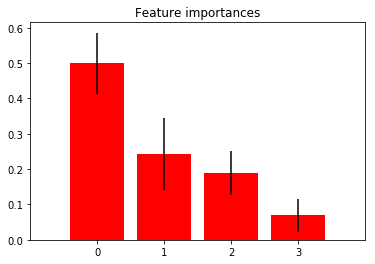

In [70]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier




# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_normalized, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## 4.	(10 points) Compare by discussing results the technique in 3 with the coefficients (W) of the logistic regression. 

### The data set from Q3 has 4 features. The algorithm in Q3 gives a feature importance. 

In a logistic regression, the algorithm also spits out weights. The logistic regression equation can be reprsented as 

$ Z = W_{0} + W_{1}.X_{1} +W_{2}.X_{2}+W_{3}.X_{3}+W_{4}.X_{4} $

where X stands for features and W stands for weights generated by the algorithm.

Differentiating the output with respect to the feature would give the corresponding feature importance 

$ \displaystyle \frac{\partial{Z}}{\partial{X_{1}}} = W_{1} , \displaystyle \frac{\partial{Z}}{\partial{X_{2}}} = W_{2}, \displaystyle \frac{\partial{Z}}{\partial{X_{3}}} = W_{3}, \displaystyle \frac{\partial{Z}}{\partial{X_{4}}} = W_{4}$

Given this, the value of the weight is an indication of its feature importance. We obviously ignore the sign of the weight.

To prove this out, I have looked at the feature importance of a logistic regression using the RFE function. The feature importance is indicated by the value of the coefficients and kinda matches with feature importance given by Q3. The logistic regression feature importance is given below.

In [75]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X, y)
clf.coef_

#print(np.std(X, 0)*clf.coef_)

array([[-3.36496558, -1.88765064, -2.30699401, -0.08893876]])

In [72]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE

# feature extraction
model = LogisticRegression()
rfe = RFE(model, 1)
fit = rfe.fit(X, y)
print("Num Features: %d" % fit.n_features_ )
print("Selected Features: %s" % fit.support_ )
print("Feature Ranking: %s" % fit.ranking_ )

Num Features: 1
Selected Features: [ True False False False]
Feature Ranking: [1 3 2 4]


In [73]:
import statsmodels.formula.api as sm
model = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.097611
         Iterations 11


In [74]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            No. Iterations:   11.0000 
Dependent Variable: y                Pseudo R-squared: 0.858   
Date:               2019-05-08 09:47 AIC:              275.8434
No. Observations:   1372             BIC:              296.7395
Df Model:           3                Log-Likelihood:   -133.92 
Df Residuals:       1368             LL-Null:          -942.56 
Converged:          1.0000           Scale:            1.0000  
-----------------------------------------------------------------
        Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-----------------------------------------------------------------
x1     -2.7285     0.2445   -11.1589   0.0000   -3.2078   -2.2493
x2     -1.6781     0.1837    -9.1344   0.0000   -2.0381   -1.3180
x3     -1.7833     0.1868    -9.5473   0.0000   -2.1495   -1.4172
x4     -0.8361     0.1322    -6.3269   0.0000   -1.0952   -0.5771
===============================================================

"""

## 5.	(20 points) Use the IRIS dataset and the binary classification (iris-setosa versus others). This dataset is imbalanced please provide a technique to oversampling that will produce a balanced dataset.

### Oversampling refers to populating the minority class with points from the same distribution as that of the minority class. This can be acheived by calcualting the parameters of the distribution. The distribution can be ascertained by assuming the data to be a mixture of the gaussian distributions and running the GMM with EM algorithm to figure out the parameters of the distributions. This method is illustrated in the following cells

In [79]:
df=pd.read_csv("iris.csv", header=None)

In [84]:
df.columns=["Feat1","Feat2","Feat3","Feat4","Class"]

In [87]:
df_setosa = df[df.Class=="Iris-setosa"]
df_setosa.head(2)

,Feat1,Feat2,Feat3,Feat4,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


In [92]:
X_set=df_setosa.iloc[:,0:4].values

### Sweep n to figure out the best number of distributions

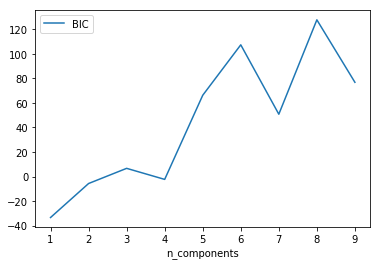

In [162]:

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

n_components =range(1,10)

models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_set)
          for n in range(1,10)]

plt.plot(n_components, [m.bic(X_set) for m in models], label='BIC')

plt.legend(loc='best')
plt.xlabel('n_components');

In [118]:
# Pick n=1 for taking the smallest 
gmm = GaussianMixture(1, covariance_type='full', random_state=0)
gmm.fit(X_set)
#Check for gmm convergence
print(gmm.converged_) 

True


In [120]:
# Generate samples
new_set = gmm.sample(50)


### This way the data can be oversampled.

## 6.	(10 points)  Describe the main differences between K-means and DB-Scan, use examples.

### K-means is a partition based algorithm, where the entire space is divided into K spaces. K-means works by minimizing the SSE. K-means starts off based on a local minima. K-means work on the assumption of spehirical clusters of data. K-means algo requires the K(number of clusters) to be provided.


### DBSCAN is a density based algorithm. This clustering is based on the assumption that areas connected by density belong to a certain cluster. DBSCAN 

The differences in the way the two algorithms works can be explained with a few examples.

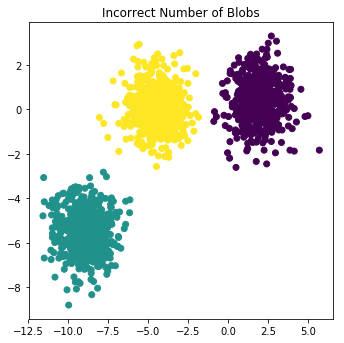

In [140]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

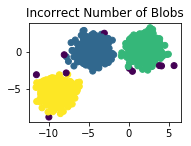

In [145]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=1, min_samples=20).fit(X)
y_pred=clustering.labels_

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Blobs with DBSCAN")

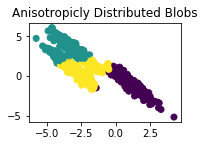

In [148]:
# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)



plt.subplot(221)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

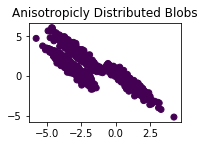

In [156]:
clustering = DBSCAN(eps=0.0001, min_samples=10).fit(X_aniso)
y_pred=clustering.labels_

plt.subplot(221)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs with DBSCAN")

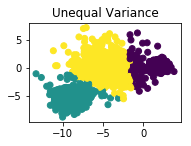

In [157]:
# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

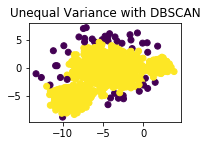

In [159]:
clustering = DBSCAN(eps=1, min_samples=10).fit(X_varied)
y_pred=clustering.labels_

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance with DBSCAN")

### The above plots illustrate the differences between K-means and DBSCAN

## 7.	(10 points) Provide a procedure to estimate the optimal number of clusters in the k-Means and Gaussian mixture model (try to differentiate the two procedure).

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [130]:
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)


For n_clusters = 2 The average silhouette_score is : 0.704978749608
For n_clusters = 3 The average silhouette_score is : 0.588200401213
For n_clusters = 4 The average silhouette_score is : 0.650518663273
For n_clusters = 5 The average silhouette_score is : 0.563764690262
For n_clusters = 6 The average silhouette_score is : 0.450466629437


### The above is a toy example where the Silhouette_score is calculated for different K values , and the K with the highest score is selected.

### As for GMM, Information theory approaches BIC can be used to make a selection of K.

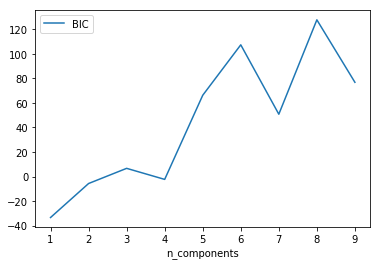

In [133]:
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_set)
          for n in range(1,10)]

plt.plot(n_components, [m.bic(X_set) for m in models], label='BIC')

plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_set)
          for n in range(1,10)]

plt.plot(n_components, [m.bic(X_set) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_set) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

## 8.	(20 points) Implement the algorithm of hierarchical clustering with maximum or complete linkage ( this can help www.econ.upf.edu/~michael/stanford/maeb7.pdf )

C:\Users\sayyapureddi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


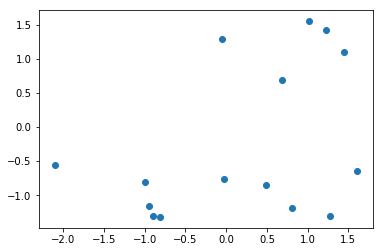

In [164]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.datasets.samples_generator import make_blobs

k = 1

class cluster_node:
    
    def __init__(self, vec, id, left=None, right=None, distance=0.0, node_vector = None):
        
        #left and right for generating dendrograms 
        
        self.leftnode = left
        self.rightnode = right
        self.vec = vec
        self.id = id
        self.distance = distance
        if node_vector is None: 
            self.node_vector = [self.id]
        else:
            self.node_vector = node_vector[:]

def euclidean_distance(vec1, vec2):
    return np.sqrt(sum((vec1 - vec2) ** 2))

def create_distance_matrix(distances, nodes):
    # Loop to ensure that only upper diagonal matrix is filled
    for i in range(len(nodes)):
        for j in range(i+1,len(nodes)):
            distances[(nodes[i].id,nodes[j].id)] = euclidean_distance(nodes[i].vec,nodes[j].vec)
    return distances

def find_clusters_to_be_merged(distances,nodes):
    closest = max(distances.values())

    for i in range(len(nodes)):
        for j in range(i+1,len(nodes)):
            d = distances[(i,j)]
            if (d > 0) & (d <= closest):
                closest = d
                lowestpair = (i,j)
    return lowestpair

def merge_nodes(lowestpair, num_nodes,nodes,deletenodeid):
    maximum = max(lowestpair)
    minimum = min(lowestpair)
    #print("lowestpair vals=", lowestpair)
    # aggregate vectors across both the merged nodes
    vec_list=[]
    vec_list.append(nodes[minimum].vec)
    vec_list.append(nodes[maximum].vec)

    nodes[minimum].vec=vec_list
    nodes[minimum].node_vector = nodes[minimum].node_vector + nodes[maximum].node_vector
    nodes[minimum].left = nodes[minimum]
    nodes[minimum].right = nodes[maximum]
    # deprecated nodes are given negative id`s.
    nodes[maximum].id = deletenodeid
    # decrease num of nodes
    num_nodes -=1
    deletenodeid -=1
    #print("deletenodeid",deletenodeid)
    return lowestpair, num_nodes, nodes, deletenodeid

def update_distance_matrix(lowestpair, distances,nodes):
    maximum = max(lowestpair)
    minimum = min(lowestpair)
    for i in range(len(nodes)):
        for j in range(i+1,len(nodes)):
            if(j==min(lowestpair)):
                distances[i,j]=max(distances[i,minimum],distances[i,maximum])
            if(j==max(lowestpair)):
                distances[i,j]=-1
    return distances

def delete_merged_nodes(nodes):
    print("len of nodes", len(nodes))
    for i in range(len(nodes)):
        if (nodes[i].id < 0):
            del nodes[i]
    return nodes

def seperate_out_wanted_nodes(nodes,list_keep_nodes):
    #print("len of nodes", len(nodes))
    for i in range(len(nodes)):
        if (nodes[i].id > 0):
            list_keep_nodes.append(nodes[i])
            
    return list_keep_nodes

# def nodes_debug(nodes):
#     print("len of nodes", len(nodes))
#     for i in range(len(nodes)):
#         #print("Node id =", nodes[i].id )
    

def agglomerative_clustering(data):
        distances = {}
        deletenodeid = -1
        list_keep_nodes=[]

        # cluster nodes are initially just the individual rows
        nodes = [cluster_node(np.array(data[i]), id=i) for i in range(len(data))]
        #print(len(nodes))
        distances = create_distance_matrix(distances, nodes)
        #print(min(distances.values()))
        #print(nodes)
        num_nodes = len(nodes)
        while num_nodes > k:
            #lowestpair = (0,1)


            lowestpair = find_clusters_to_be_merged(distances,nodes)
            #print("lowestpair vals in main=", lowestpair)
            lowestpair, num_nodes,nodes,deletenodeid = merge_nodes(lowestpair, num_nodes,nodes,deletenodeid)
            distances = update_distance_matrix(lowestpair, distances, nodes)

        #print(min(distances))
        #nodes_debug(nodes)
        #nodes = delete_merged_nodes(nodes)
        list_keep_nodes = seperate_out_wanted_nodes(nodes,list_keep_nodes)


        return list_keep_nodes

def main():
    # Generate data
    # df = pd.read_csv('./segmentation.data.modified')
    centers = [[1, 1], [-1, -1], [1, -1]]
    X, _ = make_blobs(n_samples = 15, centers = centers, cluster_std = 0.5)
    df = pd.DataFrame(X) ## convert to DF

    # Visualize the data
    f = plt.figure(1)
    plt.scatter(df[0],df[1])
    f.show()
    colorset = ['red', 'green', 'blue', 'yellow', 'brown', 'orange', 'black']

    data = np.array(df)

    # Average criterion agglomerative clustering
    cluster = agglomerative_clustering(data)
    #print("number of clusters", len(cluster))
    #print(cluster[1].node_vector)
#     j = 0
#     m = plt.figure(2)
#     for i in cluster:
#         plt.scatter(data[i.node_vector].T[0], data[i.node_vector].T[1], color = colorset[j])
#         j += 1
#     m.show()
    


if __name__ == '__main__':
    main()

        
       

